# Now, it is time for start an automated ML pipeline using the MLOps environment

We'll do that by putting a zip file, called **trainingjob.zip**, in an S3 bucket. CodePipeline will listen to that bucket and start a job. This zip file has the following structure:
 - trainingjob.json (Sagemaker training job descriptor)
 - environment.json (Instructions to the environment of how to deploy and prepare the endpoints)

### 1.1 Let's start defining the hyperparameters and other attributes

If you ran the previous section **01_CreateAlgorithmContainer** and managed to create a custom container, please change the following variable in the next cell, from:  
```Python
use_xgboost_builtin=True
```
to:
```Python
use_xgboost_builtin=False
```

---
Lets input our training parameters from our best training job from our hyperparameter tuning job


In [25]:
import sagemaker
import boto3
import time

sagemaker_session = sagemaker.Session()

# use_xgboost_builtin=True

sts_client = boto3.client("sts")
account_id = sts_client.get_caller_identity()["Account"]
region = boto3.session.Session().region_name
# model_prefix='iris-model'

model_prefix='pipeline'

In [2]:
sagemaker_session.default_bucket()

'sagemaker-us-east-1-641395199407'

We can use our optimal hyperparemters as determed by the hyper parameter tuning job:


In [3]:

# training_image = None
# hyperparameters = None
# if use_xgboost_builtin: 

training_image = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='1.0-1')
hyperparameters = {         
    "max_depth":13,
      "eta":0.16510368298823597,
      "gamma":1.2345738417970062,
      "alpha":1.7012053734536687,
      "min_child_weight":4.038526939423086,
      "subsample":0.8,
      "early_stopping_rounds":5,
      "silent":0,
      "objective":'binary:logistic',
      "eval_metric": "auc",
      "num_round":5000} 
# else:


# training_image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account_id, region, model_prefix)


# hyperparameters = {
#     "max_depth": 10,
#     "n_jobs": 5,
#     "n_estimators": 120
#     }

# training_image = '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'


print(training_image)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


### 1.2 Then, let's  create the trainingjob descriptor

In [4]:
's3://{}/{}'.format(sagemaker_session.default_bucket(), model_prefix)

's3://sagemaker-us-east-1-641395199407/Pipeline'

In [15]:
job_name

'Pipeline-2021-02-04-15-14-20'

In [6]:

roleArn = "arn:aws:iam::{}:role/MLOps".format(account_id)
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = model_prefix + timestamp
sagemaker_session = sagemaker.Session()

training_params = {}

# Here we set the reference for the Image Classification Docker image, stored on ECR (https://aws.amazon.com/pt/ecr/)
training_params["AlgorithmSpecification"] = {
    "TrainingImage": training_image,
    "TrainingInputMode": "File"
}

# The IAM role with all the permissions given to Sagemaker
training_params["RoleArn"] = roleArn

# Here Sagemaker will store the final trained model
training_params["OutputDataConfig"] = {
    "S3OutputPath": 's3://{}/{}'.format(sagemaker_session.default_bucket(), model_prefix)
}

# This is the config of the instance that will execute the training
training_params["ResourceConfig"] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 30,
    
}

# The job name. You'll see this name in the Jobs section of the Sagemaker's console
training_params["TrainingJobName"] = job_name

for i in hyperparameters:
    hyperparameters[i] = str(hyperparameters[i])
    
# Here you will configure the hyperparameters used for training your model.
training_params["HyperParameters"] = hyperparameters

# Training timeout
training_params["StoppingCondition"] = {
    "MaxRuntimeInSeconds": 360000
}

# The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
training_params["InputDataConfig"] = []

# Please notice that we're using application/x-recordio for both 
# training and validation datasets, given our dataset is formated in RecordIO

# Here we set training dataset
training_params["InputDataConfig"].append({
    "ChannelName": "train",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "S3Prefix",
            "S3Uri": 's3://{}/{}/input/train'.format(sagemaker_session.default_bucket(), model_prefix),
            "S3DataDistributionType": "FullyReplicated"
        }
    },
    "ContentType": "text/csv",
    "CompressionType": "None"
})
training_params["InputDataConfig"].append({
    "ChannelName": "validation",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "S3Prefix",
            "S3Uri": 's3://{}/{}/input/validation'.format(sagemaker_session.default_bucket(), model_prefix),
            "S3DataDistributionType": "FullyReplicated"
        }
    },
    "ContentType": "text/csv",
    "CompressionType": "None"
})
training_params["Tags"] = []

In [7]:
deployment_params = {
    "EndpointPrefix": model_prefix,
    "DevelopmentEndpoint": {
        # we want to enable the endpoint monitoring
        "InferenceMonitoring": True,
        # we will collect 100% of all the requests/predictions
        "InferenceMonitoringSampling": 100,
        "InferenceMonitoringOutputBucket": 's3://{}/{}/monitoring/dev'.format(sagemaker_session.default_bucket(), model_prefix),
        # we don't want to enable A/B tests in development
        "ABTests": False,
        # we'll use a basic instance for testing purposes
        "InstanceType": "ml.m5.large",
        "InitialInstanceCount": 1,
        # we don't want high availability/escalability for development
        "AutoScaling": None
    },
    "ProductionEndpoint": {
        # we want to enable the endpoint monitoring
        "InferenceMonitoring": True,
        # we will collect 100% of all the requests/predictions
        "InferenceMonitoringSampling": 100,
        "InferenceMonitoringOutputBucket": 's3://{}/{}/monitoring/prd'.format(sagemaker_session.default_bucket(), model_prefix),
        # we want to do A/B tests in production
        "ABTests": True,
        # we'll use a better instance for production. CPU optimized
        "InstanceType": "ml.m5.large",
        "InitialInstanceCount": 2,
        "InitialVariantWeight": 0.1,
        # we want elasticity. at minimum 2 instances to support the endpoint and at maximum 10
        # we'll use a threshold of 750 predictions per instance to start adding new instances or remove them
        "AutoScaling": {
            "MinCapacity": 2,
            "MaxCapacity": 10,
            "TargetValue": 200.0,
            "ScaleInCooldown": 30,
            "ScaleOutCooldown": 60,
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance"
        }
    }
}

#### Preparing and uploading the dataset

In [8]:
import numpy as np
import sagemaker
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

# iris = datasets.load_iris()
# iris

In [9]:
pwd

'/home/ec2-user/SageMaker/CI-CD-Pipeline/lab'

In [24]:
model_prefix

'pipeline-model'

In [13]:
import numpy as np
import sagemaker
from sklearn import datasets
from sklearn.model_selection import train_test_split

# sagemaker_session = sagemaker.Session()
# iris = datasets.load_iris()

# prefix='mlops/iris'

# X_train, X_test, y_train, y_test = train_test_split(
#     iris.data, iris.target, test_size=0.33, random_state=42, stratify=iris.target)
# np.savetxt("iris_train.csv", np.column_stack((y_train, X_train)), delimiter=",", fmt='%0.3f')
# np.savetxt("iris_test.csv", np.column_stack((y_test, X_test)), delimiter=",", fmt='%0.3f')

# Upload the dataset to an S3 bucket
input_train = sagemaker_session.upload_data(path='train_data.csv', key_prefix='%s/input/train' % model_prefix)
input_test = sagemaker_session.upload_data(path='validation_data.csv', key_prefix='%s/input/validation' % model_prefix)

### 1.3 Alright! Now it's time to start the training process

In [29]:
import boto3
import io
import zipfile
import json

s3 = boto3.client('s3')
sts_client = boto3.client("sts")

session = boto3.session.Session()

account_id = sts_client.get_caller_identity()["Account"]
region = session.region_name

bucket_name = "mlops-%s-%s" % (region, account_id)
key_name = "training_jobs/%s/trainingjob.zip" % model_prefix
# key_name = "training_jobs/iris-model/trainingjob.zip"

# need to change training job key name from iris, since source in cloudpipline is pointing to iris folder
# key_name = "training_jobs/%s/trainingjob.zip" % model_prefix

zip_buffer = io.BytesIO()
with zipfile.ZipFile(zip_buffer, 'a') as zf:
    zf.writestr('trainingjob.json', json.dumps(training_params))
    zf.writestr('deployment.json', json.dumps(deployment_params))
zip_buffer.seek(0)

# s3.put_object(Bucket=bucket_name, Key=key_name, Body=bytearray(zip_buffer.read()))
s3.put_object(Bucket=bucket_name, Key=key_name, Body=bytearray(zip_buffer.read()))

{'ResponseMetadata': {'RequestId': 'FRFH9X9G9Q4J9WBW',
  'HostId': 'cxyo7n960yIfmaCY7M9OZdC6MPh9e1+RfNwsUaJj8ELRSD81re8UtA25LXr6AOup5bpugEH/2mY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'cxyo7n960yIfmaCY7M9OZdC6MPh9e1+RfNwsUaJj8ELRSD81re8UtA25LXr6AOup5bpugEH/2mY=',
   'x-amz-request-id': 'FRFH9X9G9Q4J9WBW',
   'date': 'Thu, 04 Feb 2021 15:52:11 GMT',
   'x-amz-version-id': 'gUnrp._YarByy260MCBgNjHyluMP38_C',
   'etag': '"79ad91b525f87b5c4265bfb23f9bea35"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"79ad91b525f87b5c4265bfb23f9bea35"',
 'VersionId': 'gUnrp._YarByy260MCBgNjHyluMP38_C'}

In [27]:
bucket_name

'mlops-us-east-1-641395199407'

In [28]:
key_name

'training_jobs/pipeline/trainingjob.zip'

### Ok, now open the AWS console in another tab and go to the CodePipeline console to see the status of our building pipeline

> Now, click on [THIS NOTEBOOK](02_Check%20Progress%20and%20Test%20the%20endpoint.ipynb) to see the progress and test your endpoint

# Now let's monitor the training/deploying process

In [58]:
import boto3
import ipywidgets as widgets
import time

from IPython.display import display

## Helper functions

In [2]:
# def get_actions():
#     actions = []
#     executionId = None
#     resp = codepipeline.get_pipeline_state( name=pipeline_name )
#     for stage in resp['stageStates']:
#         stageName = stage['stageName']
#         stageStatus = None
#         if stage.get('latestExecution') is not None:
#             stageStatus = stage['latestExecution']['status']
#             if executionId is None:
#                 executionId = stage['latestExecution']['pipelineExecutionId']
#             elif stage['latestExecution']['pipelineExecutionId'] != executionId:
#                 stageStatus = 'Old'
#         for action in stage['actionStates']:
#             actionName = action['actionName']
#             actionStatus = 'Old'
#             if action.get('latestExecution') is not None and stageStatus != 'Old':
#                 actionStatus = action['latestExecution']['status']
#             actions.append( {'stageName': stageName, 
#                              'stageStatus': stageStatus, 
#                              'actionName': actionName, 
#                              'actionStatus': actionStatus})
#     return actions

In [3]:
# def get_approval_token():
#     resp = codepipeline.get_pipeline_state( name=pipeline_name )
#     token = None
#     # Get the approve train status token
#     for stageState in resp['stageStates']:
#         if stageState['stageName'] == 'DeployApproval':
#             for actionState in stageState['actionStates']:
#                 if actionState['actionName'] == 'ApproveDeploy':
#                     if actionState.get('latestExecution') is None:
#                         return None
#                     latestExecution = actionState['latestExecution']
#                     if latestExecution['status'] == 'InProgress':
#                         token = latestExecution['token']
#     return token

In [59]:
from sagemaker.serializers import CSVSerializer
csv_serializer = CSVSerializer()
def test_endpoint(endpoint_name, payload):
    resp = sm.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='text/csv',
        Accept='text/csv',
        Body=csv_serializer.serialize(payload)
    )
    variant_name = resp['ResponseMetadata']['HTTPHeaders']['x-amzn-invoked-production-variant']
    return float(resp['Body'].read().decode('utf-8').strip()), variant_name

In [5]:
# def approval(token, result):
#     if token is None:
#         return
    
#     codepipeline.put_approval_result(
#       pipelineName=pipeline_name,
#       stageName='DeployApproval',
#       actionName='ApproveDeploy',
#       result=result,
#       token=token
#     )

In [6]:
# def approve(b):
#     result={
#         'summary': 'This is a great model! Put into production.',
#         'status': 'Approved'
#     }
#     approval(get_approval_token(), result) 
#     button_box.close()
#     start_monitoring()

In [7]:
# def reject(b):
#     result={
#         'summary': 'This is a rubbish model. Discard it',
#         'status': 'Rejected'
#     }
#     approval(get_approval_token(), result)
#     button_box.close()
#     start_monitoring()

In [8]:
# def start_monitoring():
#     global button_box
    
#     running = True
#     while running:
#         steps_ok = 0
#         for k,action in enumerate(get_actions()):
#             if action['actionStatus'] == 'Failed':
#                 bar.bar_style='danger'
#                 label.value='Ops! Something went wrong Stage[{}] Action[{}]'.format(
#                     action['stageName'], action['actionName'])
#                 running = False
#                 return

#             elif action['actionStatus'] == 'InProgress':
#                 if get_approval_token() is not None:
#                     display(button_box)
#                     running = False
#                 break
#             elif action['actionStatus'] == 'Old':
#                 break
#             elif action['actionStatus'] == 'Succeeded':
#                 steps_ok += 1
        
#         label.value = "Actions {}/{} - Current: Stage[{}] Action[{}]".format( 
#                 k+1,max_actions, action['stageName'], action['actionName'] )
#         bar.value = steps_ok

#         if steps_ok == max_actions:
#             running = False
#         else:    
#             time.sleep(2)

## Job monitoring

In [74]:
codepipeline = boto3.client('codepipeline')
sm = boto3.client('sagemaker-runtime')

model_prefix='pipeline-model'
pipeline_name = 'iris-model-pipeline'
endpoint_name_mask='{}-%s'.format(model_prefix)

In [75]:
endpoint_name_mask

'Pipeline-%s'

In [10]:
# approve_btn = widgets.Button(description="Approve", button_style='success', icon='check')
# reject_btn = widgets.Button(description="Reject", button_style='danger', icon='close')
# approve_btn.on_click(approve)
# reject_btn.on_click(reject)
# button_box = widgets.HBox([approve_btn, reject_btn])
                
# max_actions = len(get_actions())
# label = widgets.Label(value="Loading...")
# bar = widgets.IntProgress( value=0, min=0, max=max_actions, step=1, bar_style='info' )
# info_box = widgets.VBox([label, bar])

# display(info_box)
# start_monitoring()

## Now, if everything went fine, we can test our models

In [60]:
from numpy import genfromtxt
testnp = genfromtxt('test_data.csv', delimiter=',')
testnp


array([[  0., 186.,   0., ...,   0.,   1.,   0.],
       [  0., 132.,  25., ...,   0.,   0.,   1.],
       [  0., 112.,  17., ...,   0.,   0.,   1.],
       ...,
       [  0.,  86.,   0., ...,   0.,   1.,   0.],
       [  0.,  36.,  43., ...,   0.,   0.,   1.],
       [  0., 123.,   0., ...,   0.,   1.,   0.]])

# A/B TESTING

If you take a look on the **deployment** parameters you'll see that we enabled the **Production** endpoint for A/B tests. To try this, just deploy the first model into production, then run the section **1.3** again. Feel free to change some hyperparameter values in the section **1.1** before starting a new training session.

When publishing the second model into **Development**, the endpoint will be updated and the model will be replaced without compromising the user experience. This is the natural behavior of an Endpoint in SageMaker when you update it.

After you approve the deployment into **Production**, the endponint will be updated and a second model will be added to it. Now it's time to execute some **A/B tests**. In the **Progress** Jupyter (link above), execute the last cell (test code) to show which model answered your request. You just need to keep sending some requests to see the **Production** endpoint using both models A and B, respecting the proportion defined by the variable **InitialVariantWeight** in the deployment params.

In a real life scenario you can monitor the performance of both models and then adjust the **Weight** of each model to do the full transition to the new model (and remove the old one) or to rollback the new deployment.

To adjust the weight of each model (Variant Name) in an endpoint, you just need to call the following function: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.update_endpoint_weights_and_capacities

In [69]:
import csv
from csv import reader
# open file in read mode
with open('test_data.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        # row variable is a list that represents a row in csv
        print(row)

['0.000', '186.000', '0.000', '137.800', '97.000', '187.700', '118.000', '146.400', '85.000', '8.700', '6.000', '1.000', '0.000', '0.000', '1.000', '1.000', '0.000', '1.000', '0.000']
['0.000', '132.000', '25.000', '113.200', '96.000', '269.900', '107.000', '229.100', '87.000', '7.100', '7.000', '2.000', '0.000', '1.000', '0.000', '1.000', '0.000', '0.000', '1.000']
['0.000', '112.000', '17.000', '183.200', '95.000', '252.800', '125.000', '156.700', '95.000', '9.700', '3.000', '0.000', '0.000', '1.000', '0.000', '1.000', '0.000', '0.000', '1.000']
['0.000', '91.000', '24.000', '93.500', '112.000', '183.400', '128.000', '240.700', '133.000', '9.900', '3.000', '0.000', '0.000', '0.000', '1.000', '0.000', '1.000', '0.000', '1.000']
['0.000', '22.000', '0.000', '110.300', '107.000', '166.500', '93.000', '202.300', '96.000', '9.500', '5.000', '0.000', '1.000', '0.000', '0.000', '1.000', '0.000', '1.000', '0.000']
['0.000', '102.000', '0.000', '186.800', '92.000', '173.700', '123.000', '250.

In [156]:
%%time
payload = [118.000, 21.000, 156.500, 122.000, 209.200, 125.000, 158.700, 81.000, 11.100, 3.000, 4.000, 1.000, 0.000, 0.000, 0.000, 1.000, 0.000, 1.000]

print( "DSV")
print( "Classifier: %s, Variant Name: %s" % test_endpoint( endpoint_name_mask % ('development'), payload ) )

print( "PRD")
print( "Classifier: %s, Variant Name: %s" % test_endpoint( endpoint_name_mask % ('production'), payload ) )

DSV
Classifier: 0.6951175928115845, Variant Name: model-a
PRD
Classifier: 0.6951175928115845, Variant Name: model-a
CPU times: user 6.95 ms, sys: 645 µs, total: 7.6 ms
Wall time: 25.6 ms


In [83]:
pwd

'/home/ec2-user/SageMaker/ML-CI-CD2/lab/02_TrainYourModel'

In [84]:
test_data = pd.read_csv('test_data.csv')
test_data

,0.000,186.000,0.000.1,137.800,97.000,187.700,118.000,146.400,85.000,8.700,6.000,1.000,0.000.2,0.000.3,1.000.1,1.000.2,0.000.4,1.000.3,0.000.5
0,0.0,132.0,25.0,113.2,96.0,269.9,107.0,229.1,87.0,7.1,7.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,112.0,17.0,183.2,95.0,252.8,125.0,156.7,95.0,9.7,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,91.0,24.0,93.5,112.0,183.4,128.0,240.7,133.0,9.9,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,22.0,0.0,110.3,107.0,166.5,93.0,202.3,96.0,9.5,5.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,102.0,0.0,186.8,92.0,173.7,123.0,250.9,131.0,9.7,4.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0.0,59.0,0.0,166.3,95.0,239.3,87.0,123.2,108.0,10.0,3.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
329,0.0,127.0,14.0,143.2,99.0,169.9,91.0,221.6,77.0,11.6,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
330,0.0,86.0,0.0,166.2,112.0,255.3,81.0,228.1,97.0,5.4,7.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
331,0.0,36.0,43.0,29.9,123.0,129.1,117.0,325.9,105.0,8.6,6.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [100]:
xgb_predictor4 = sagemaker.predictor.Predictor('Pipeline-production', sagemaker_session=None, serializer=CSVSerializer())

In [81]:
xgb_predictor3 = sagemaker.predictor.Predictor('Pipeline-development', sagemaker_session=sess, serializer=CSVSerializer())

In [108]:
def predict(data, rows=2000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor4.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:,1:])
predictions

array([0.04594088, 0.04338237, 0.12121402, 0.04115116, 0.05016112,
       0.69511759, 0.04656969, 0.13465706, 0.04349471, 0.06287679,
       0.05450993, 0.04115116, 0.07602978, 0.05016112, 0.07992861,
       0.04376415, 0.04624721, 0.33008528, 0.04115116, 0.04624721,
       0.61024028, 0.0561538 , 0.04115116, 0.05498401, 0.10902666,
       0.04115116, 0.93427795, 0.04620972, 0.05279603, 0.04115116,
       0.07571053, 0.04349471, 0.04115116, 0.04338237, 0.63448483,
       0.04349471, 0.04115116, 0.05881285, 0.06918161, 0.04115116,
       0.10668433, 0.05279603, 0.04624721, 0.05202799, 0.81295007,
       0.04975453, 0.04115116, 0.05450993, 0.05256119, 0.04452354,
       0.05016112, 0.14879617, 0.05016112, 0.33982924, 0.04115116,
       0.04554102, 0.54581392, 0.04624721, 0.05240234, 0.22197875,
       0.04115116, 0.10079587, 0.04624721, 0.04656969, 0.04376415,
       0.04115116, 0.04115116, 0.07528707, 0.04624721, 0.04656969,
       0.31009188, 0.04115116, 0.08172955, 0.05162812, 0.67544

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [92]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0.0,282,3
1.0,12,36


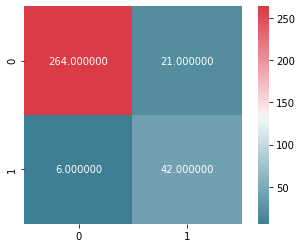

In [93]:
cfm = confusion_matrix(test_data.iloc[:, 0], np.where(predictions > 0.2, 1, 0))
sns.heatmap(cfm, annot=True, fmt="f", square=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [ ]:
# %%time
# payload = [4.6, 3.1, 1.5, 0.2]

# print( "DSV")
# print( "Classifier: %s, Variant Name: %s" % test_endpoint( endpoint_name_mask % ('development'), payload ) )

# print( "\nPRD")
# print( "Classifier: %s, Variant Name: %s" % test_endpoint( endpoint_name_mask % ('production'), payload ) )

# Stress Test

The idea of this code is to see how the production Endpoint will behave when a **bunch** of requests arrive it.
Let's simulate several users doing predictions at the same time

In [1]:
import threading
import boto3
import numpy as np
import time
import math

from multiprocessing.pool import ThreadPool
from sklearn import datasets

In [4]:
pwd

'/home/ec2-user/SageMaker/ML-CI-CD2/lab/03_TestingHacking'

In [14]:
sm = boto3.client("sagemaker-runtime")

endpoint_name_mask='iris-model-%s'

iris = datasets.load_iris()
dataset2 = np.insert(iris.data, 0, iris.target,axis=1)

In [15]:
dataset2

array([[0. , 5.1, 3.5, 1.4, 0.2],
       [0. , 4.9, 3. , 1.4, 0.2],
       [0. , 4.7, 3.2, 1.3, 0.2],
       [0. , 4.6, 3.1, 1.5, 0.2],
       [0. , 5. , 3.6, 1.4, 0.2],
       [0. , 5.4, 3.9, 1.7, 0.4],
       [0. , 4.6, 3.4, 1.4, 0.3],
       [0. , 5. , 3.4, 1.5, 0.2],
       [0. , 4.4, 2.9, 1.4, 0.2],
       [0. , 4.9, 3.1, 1.5, 0.1],
       [0. , 5.4, 3.7, 1.5, 0.2],
       [0. , 4.8, 3.4, 1.6, 0.2],
       [0. , 4.8, 3. , 1.4, 0.1],
       [0. , 4.3, 3. , 1.1, 0.1],
       [0. , 5.8, 4. , 1.2, 0.2],
       [0. , 5.7, 4.4, 1.5, 0.4],
       [0. , 5.4, 3.9, 1.3, 0.4],
       [0. , 5.1, 3.5, 1.4, 0.3],
       [0. , 5.7, 3.8, 1.7, 0.3],
       [0. , 5.1, 3.8, 1.5, 0.3],
       [0. , 5.4, 3.4, 1.7, 0.2],
       [0. , 5.1, 3.7, 1.5, 0.4],
       [0. , 4.6, 3.6, 1. , 0.2],
       [0. , 5.1, 3.3, 1.7, 0.5],
       [0. , 4.8, 3.4, 1.9, 0.2],
       [0. , 5. , 3. , 1.6, 0.2],
       [0. , 5. , 3.4, 1.6, 0.4],
       [0. , 5.2, 3.5, 1.5, 0.2],
       [0. , 5.2, 3.4, 1.4, 0.2],
       [0. , 4

In [24]:
genfromtxt??

Signature:
genfromtxt(
    fname,
    dtype=<class 'float'>,
    comments='#',
    delimiter=None,
    skip_header=0,
    skip_footer=0,
    converters=None,
    missing_values=None,
    filling_values=None,
    usecols=None,
    names=None,
    excludelist=None,
    deletechars=" !#$%&'()*+,-./:;<=>?@[\\]^{|}~",
    replace_space='_',
    autostrip=False,
    case_sensitive=True,
    defaultfmt='f%i',
    unpack=None,
    usemask=False,
    loose=True,
    invalid_raise=True,
    max_rows=None,
    encoding='bytes',
)
Source:   
@set_module('numpy')
def genfromtxt(fname, dtype=float, comments='#', delimiter=None,
               skip_header=0, skip_footer=0, converters=None,
               missing_values=None, filling_values=None, usecols=None,
               names=None, excludelist=None,
               deletechars=''.join(sorted(NameValidator.defaultdeletechars)),
               replace_space='_', autostrip=False, case_sensitive=True,
               defaultfmt="f%i", unpack=None, usem

In [31]:
from numpy import genfromtxt
dataset = genfromtxt('model_data.csv', delimiter=',', skip_header=1)
dataset

array([[0.000e+00, 0.000e+00, 1.280e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.000e+00, 0.000e+00, 1.070e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.000e+00, 0.000e+00, 1.370e+02, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [3.330e+03, 0.000e+00, 2.800e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.331e+03, 0.000e+00, 1.840e+02, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [3.332e+03, 0.000e+00, 7.400e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

In [36]:
dataset.shape

(3333, 71)

In [42]:
dataset3 = dataset[:,1:]
dataset3.shape

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [20]:
from sagemaker.serializers import CSVSerializer

def predict(payload):
    csv_serializer = CSVSerializer()
    payload = payload
    X = payload[1:]
    y = payload[0]
    
    elapsed_time = time.time()
    resp = sm.invoke_endpoint(
        EndpointName=endpoint_name_mask % env,
        ContentType='text/csv',
        Accept='text/csv',
        Body=csv_serializer.serialize(X)
    )
    elapsed_time = time.time() - elapsed_time
    resp = float(resp['Body'].read().decode('utf-8').strip())
    return (resp == y, elapsed_time)

In [38]:
def run_test(max_threads, max_requests):
    num_batches = math.ceil(max_requests / len(dataset3))
    requests = []
    for i in range(num_batches):
        batch = dataset3.copy()
        np.random.shuffle(batch)
        requests += batch.tolist()
    len(requests)

    pool = ThreadPool(max_threads)
    result = pool.map(predict, requests)
    pool.close()
    pool.join()
    
    correct_random_forest=0
    elapsedtime_random_forest=0
    for i in result:
        correct_random_forest += i[0]
        elapsedtime_random_forest += i[1]
    print("Score classifier: {}".format(correct_random_forest/len(result)))

    print("Elapsed time: {}s".format(elapsedtime_random_forest))

In [39]:
env='production'

In [40]:
%%time
print("Starting test 1")
run_test(10, 1000)

Starting test 1
Score classifier: 0.0
Elapsed time: 74.21926283836365s
CPU times: user 8.96 s, sys: 433 ms, total: 9.39 s
Wall time: 8.86 s


In [41]:
%%time
print("Starting test 2")
run_test(100, 10000)

Starting test 2



KeyboardInterrupt



In [ ]:
%%time
print("Starting test 3")
run_test(150, 100000000)

> While this test is running, go to the **AWS Console** -> **Sagemaker**, then click on the **Endpoint** and then click on the **CloudWatch** monitoring logs to see the Endpoint Behavior

## In CloudWatch, mark the following three checkboxes
![CloudWatchA](../../imgs/CloudWatchA.png)

## Then, change the following config, marked in RED

![CloudWatchB](../../imgs/CloudWatchB.png)

## Now, while your stress test is still running, you will see the Auto Scaling Alarm like this, after 3 datapoints above 750 Invocations Per Instance

![CloudWatchC](../../imgs/CloudWatchC.png)

When this happens, the Endpoint Autoscaling will start adding more instances to your cluster. You can observe in the Graph from the previous image that, after new instances are added to the cluster, the **Invocations** metrics grows.

## Well done!